In [1]:
from astropy.io import fits
import pandas as pd

In [2]:
from pathlib import Path

In [3]:
from importlib import reload
from utils import ks2_utils, shared_utils, image_utils

In [4]:
import re

# INPUT.KS2

In [5]:
ks2_filtermapper = ks2_utils.get_filter_mapper()

In [6]:
ks2_filemapper = ks2_utils.get_file_mapper()

# LOGR.XYVIQ1

LOGR.XYVIQ1 gives the average position for each source on the master frame (cols 1 and 2), the average flux (cols 5 and 11), the flux sigma (cols 6 and 12), and fit quality (cols 7 and 13) in each filter)


In [7]:
reload(ks2_utils)
master_catalog_df = ks2_utils.get_master_catalog()

In [8]:
master_catalog_df.head()

,umast0,vmast0,mmast1,NMAST,zmast1,szmast1,q1,o1,f1,g1,zmast2,szmast2,q2,o2,f2,g2
0,736.37,91.51,-2.3045,R0000001,8.352,2.586,0.900,0.01,9,9,14.088,1.538,0.963,0.01,9,9
1,737.04,34.36,-3.2771,R0000002,20.458,2.260,0.899,0.00,9,9,9.987,2.508,0.909,0.00,16,16
2,740.65,61.26,-5.9669,R0000003,243.655,3.332,0.999,0.01,9,9,177.850,2.386,0.999,0.02,9,9
3,745.91,93.19,-2.9646,R0000004,15.340,1.092,0.968,0.01,9,9,19.786,2.601,0.982,0.01,9,9
4,749.93,124.75,-4.4803,R0000005,61.959,3.305,0.997,0.00,9,9,84.200,2.850,0.998,0.00,18,18


# LOGR.FIND_NIMFO


In [9]:
reload(ks2_utils)
point_sources_df = ks2_utils.get_point_source_catalog(clean=True)

/Users/jaguilar/miniconda3/envs/astro37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (20,28,34) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [10]:
point_sources_df.head(5)

,umast,vmast,magu,utile,vtile,z0,sz0,f0,g0,u1,...,o3,f3,g3,NMAST,ps_tile_id,tile_id,master_exp_id,filt_id,unk,chip_id
0,736.424,91.482,-2.0238,0.0,0.0,6.5,0.8,0,True,31.849,...,0.0,1,True,R0000001,L005,N001,G004,F1,C,1
1,736.459,91.452,-1.4531,0.0,0.0,3.7,0.8,0,True,31.918,...,0.0,1,True,R0000001,L005,N002,G006,F1,C,1
2,736.323,91.491,-2.5450,0.0,0.0,10.4,0.8,0,True,31.646,...,0.0,1,True,R0000001,L005,N003,G007,F1,C,1
3,736.306,91.445,-2.2584,0.0,0.0,8.3,0.8,0,True,31.611,...,0.0,1,True,R0000001,L005,N004,G009,F1,C,1
4,736.398,91.671,-2.5036,0.0,0.0,9.6,0.8,0,True,31.797,...,0.0,1,True,R0000001,L005,N005,G010,F1,C,1


# Diagnostic plots

In [11]:
figpath = Path("./figs/ks2/")

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns

In [13]:
reload(image_utils)

<module 'utils.image_utils' from '/user/jaguilar/tr14/code/utils/image_utils.py'>

In [14]:
# Let's plot z, sz, q, and o for the 100 brightest star
# I guess I should also come up with an inspector?

In [15]:
system_type_flags = {1: 'single', # no other stars are visible in the frame
                     2: 'wide binary', # second star is visible in the stamp with little PSF overlap
                     3: 'close binary' # second star is visible in the stamp with some PSF overlap
                    }

In [16]:
# find the brightest stars
start = 0
end = start + 9
brightest_stars = master_catalog_df.sort_values(by='zmast1', ascending=False).reset_index(drop=True).reset_index(drop=True)

In [17]:
reload(image_utils)

<module 'utils.image_utils' from '/user/jaguilar/tr14/code/utils/image_utils.py'>

# OK, reduce the data size.

There's a lot of data, so let's pick a random 10% of it to make plotting a lot faster

In [18]:
rand_rows = point_sources_df.index.values.copy()
np.random.shuffle(rand_rows) # choose variables at random
ps_df = point_sources_df.loc[rand_rows[:len(rand_rows)//10]].copy() # just plot 10% of the data

# First let's look at the distribution in the master frame

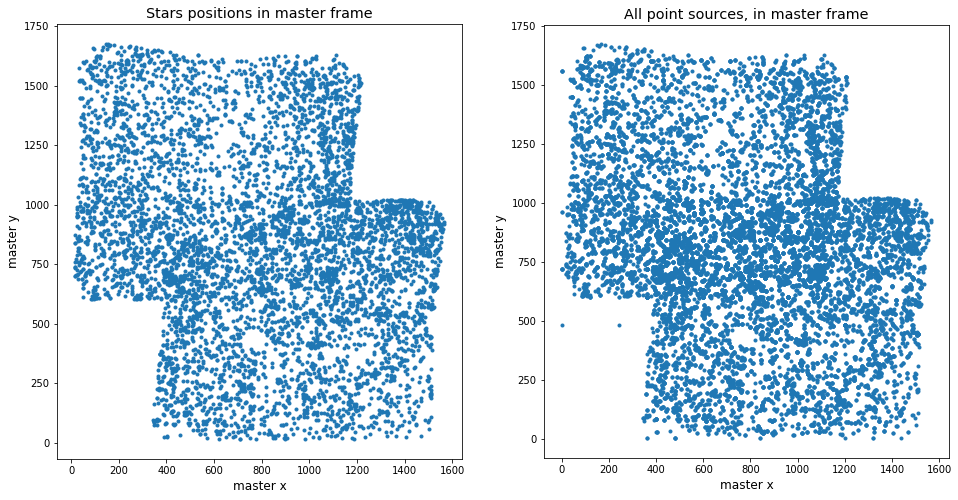

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
ax = axes[0]
ax.set_xlabel("master x")
ax.set_ylabel("master y")
ax.set_title("Stars positions in master frame")
ax.scatter(master_catalog_df['umast0'], master_catalog_df['vmast0'],
           marker='.')
ax.set_aspect('equal')



ax = axes[1]
ax.set_xlabel("master x")
ax.set_ylabel("master y")
ax.set_title("All point sources, in master frame")
ax.scatter(ps_df['umast'], ps_df['vmast'],
           marker='.')
ax.set_aspect('equal')


# Do correlation plots for the point sources

In [20]:
"""
Select the columns to plot - drop all text columns, and all the f# and g# columns
"""
plot_columns = list(ps_df.columns[:-7])
pop_ind = []
for i, col in enumerate(plot_columns):
    colregex = re.compile('[fg][0-9]+|[uv]mast|[uv]tile')
    search = colregex.search(col)
    if search is not None:
        pop_ind.append(i)
plot_columns = list(np.delete(plot_columns, pop_ind))
print(len(plot_columns), plot_columns)

23 ['magu', 'z0', 'sz0', 'u1', 'v1', 'x1', 'y1', 'xraw1', 'yraw1', 'z1', 'sz1', 'q1', 'o1', 'x0', 'y0', 'z2', 'sz2', 'q2', 'o2', 'z3', 'sz3', 'q3', 'o3']


In [21]:
# some categories need to be log-scaled
# pairax = sns.pairplot(ps_df.loc[::5], vars=plot_columns, 
#                       diag_kws={'bins':50}, 
#                       plot_kws={'size':10, 'marker':'.'},
#                      corner=True)
# pairax.fig.savefig(figpath / "pairplots.png", bbox_inches='tight')

In [22]:
# # First, histogram all the variables
# np.random.shuffle(rand_rows) # choose variables at random
# rows_to_plot = rand_rows[:len(rand_rows)//10] # plot 10% of the data
# df = point_sources_df.loc[rows_to_plot]

# ncols = 4
# nrows = len(plot_columns)//ncols 
# nrows += int(nrows*ncols < len(plot_columns))
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4*ncols, 4*nrows))
# for i, col in enumerate(plot_columns):
#     ax = axes.ravel()[i]
#     ax.set_ylabel("N")
#     ax.set_xlabel(col)
#     # all variables except x and y should be plotted on a log scale
#     log_flag = True if re.search('[xy]', col) is None else False
#     ax.hist(df[col], bins=100, log=log_flag)
# if False:
#     fig.savefig(figpath / "histos.pdf")

In [23]:
# fig, ax = plt.subplots()
# for i in range(len(plot_columns)):
#     for j in range(i,len(plot_columns)):
#         fig, ax = plt.subplots(1, 1)
#         ax.scatter()

## Compute distance matrices for stars in the same exposure, then you can pick stars that are close to each other

In [24]:
"""
exp_gb = ps_df.groupby("master_exp_id") # group by exposure

group = exp_gb.get_group('G001')
group[['xraw1','yraw1']]

dist_matrices = {k: pd.DataFrame(np.zeros((v.size, v.size)), index=v, columns=v) for k,v in exp_gb.groups.items()}
for k, v in exp_gb.groups.items():
    pass

for k, v in gexp

for g, v in exp_gb.groups.items():
    group = exp_gb.get_group(g)
    for ind in dist_matrices[g].index:
        dist_matrices[g].loc[ind] = (group[['xraw1', 'yraw1']] - group.loc[ind, ['xraw1', 'yraw1']]).apply(np.linalg.norm, axis=1)



group_id = list(exp_gb.groups.keys())[1]
fig, ax = plt.subplots(1, 1)
img = ax.pcolor(dist_matrices[group_id].loc[::10,::10])
ax.set_xlabel("Point source index (not shown)")
ax.set_ylabel("Point source index (not shown)")
ax.set_title("Distance matrix")
ax.set_xticklabels('')
ax.set_yticklabels('')
cbar = plt.colorbar(img)
cbar.set_label('dist [pix]')
fig.savefig(figpath / f"distmat-{group_id}.png")
""";

## Let's look at some stamps
just start from the brightest star
1. Pick a star
2. Plot a stamp
3. Plot the x and y on the stamp
4. Compute the distance for the remaining point sources
5. Plot the closest ones on the stamp

In [25]:
target = brightest_stars.loc[0, 'NMAST']

In [26]:
brightest_stars.head(5)

,umast0,vmast0,mmast1,NMAST,zmast1,szmast1,q1,o1,f1,g1,zmast2,szmast2,q2,o2,f2,g2
0,890.33,886.85,-12.8568,R0003688,138911.141,681.767,0.999,2.86,2,2,138139.625,2132.587,0.999,2.94,10,10
1,946.98,1326.65,-12.6689,R0005481,116826.969,9999.900,1.000,944.41,2,1,114944.219,2783.895,1.000,2488.15,11,6
2,699.97,452.63,-12.6607,R0001217,115947.625,9999.900,1.000,1.21,1,1,105570.305,1779.096,0.999,1.24,12,12
3,796.43,642.13,-12.5949,R0002206,109132.336,1475.222,0.998,2.74,6,6,111699.477,9273.528,0.999,2.89,22,21
4,991.21,734.01,-12.4650,R0002481,96826.672,1409.509,0.999,1.96,8,8,91708.797,2146.511,0.999,2.02,32,31


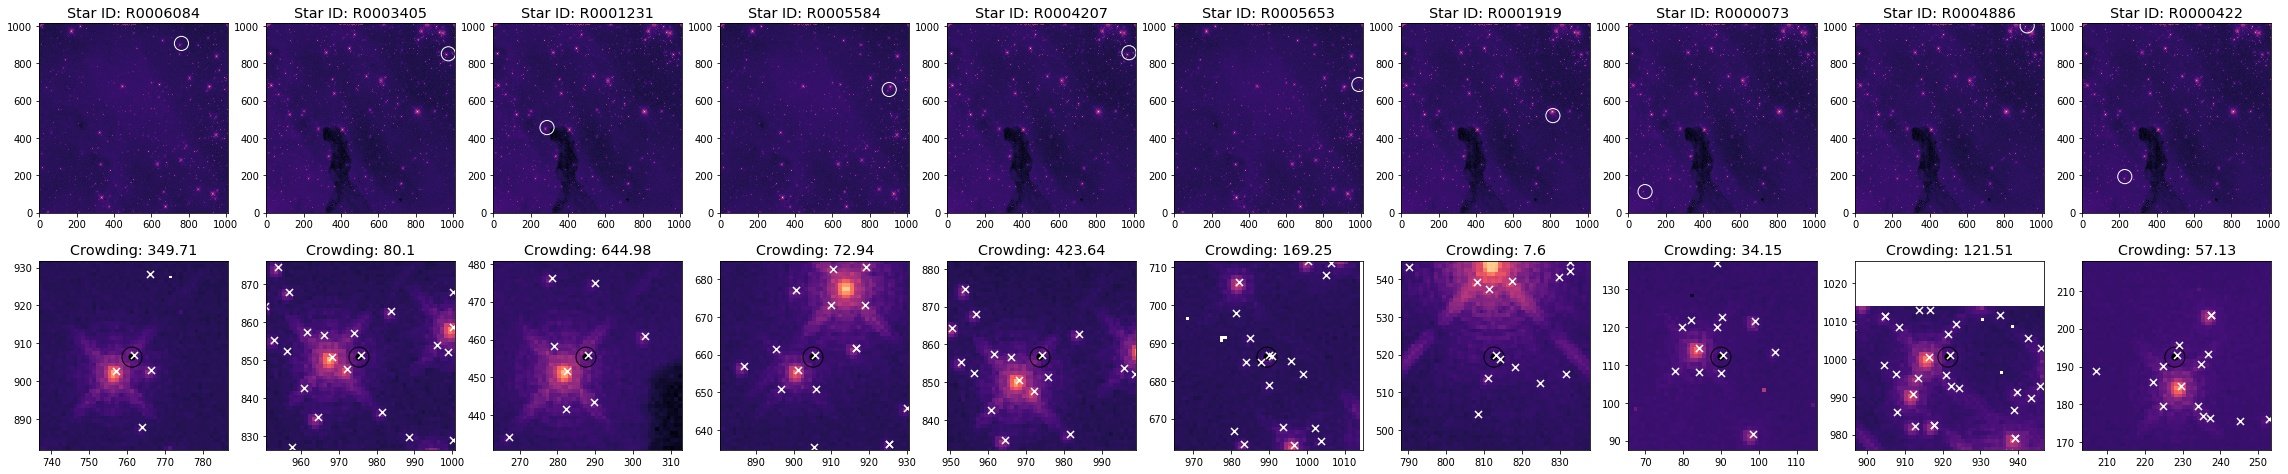

In [27]:
# for each of the brightest stars, get a stamp of every detection and plot them all together
#for star_ind in brightest_stars.index:
star_ind = 0

fig, all_axes = plt.subplots(nrows=2, ncols=10, figsize=(4*10, 4*2))
for i, star_ind in enumerate(brightest_stars.index[::-1][:10]):
    axes = all_axes.T[i]
    target_star = brightest_stars.loc[star_ind, 'NMAST']
    ps = point_sources_df.query("NMAST == '{0}' and filt_id == '{1}'".format(target_star, 'F1')).reset_index(drop=True)

    # common formatting
    imshow_args = {'cmap':'magma', 
                   'norm': mpl.colors.LogNorm(vmin=1, vmax=brightest_stars['zmast1'].max())}

    #fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    #ax.set_title(f"Star ID: {target_star}\nCrowding: {brightest_stars.loc[star_ind, 'o1']}", y=0.75)
    # fig.tight_layout()#rect=[0, 0, 1, 0.97])

    row = ps.loc[0]
    # find the file and get the data
    file_name = ks2_filemapper.query(f"file_id == '{row.master_exp_id}'")['file_name'].values[0]
    file_name = shared_utils.data_path / file_name
    data = fits.getdata(file_name, 'SCI')

    # plot the full-frame image
    ax = axes[0]
    ax.set_title(f"Star ID: {target_star}")
    ax.pcolormesh(data, **imshow_args)
    ax.scatter(*row[['xraw1','yraw1']], 
               marker='o', s=200, ec='w', fc='none')
    ax.set_aspect('equal')
    ax.set_xlim(0, data.shape[1])
    ax.set_ylim(0, data.shape[0])

    # zoom in on the star
    ax = axes[1]
    
    # cut out a stamp
    stamp_shape = 50
    # stamp = image_utils.get_stamp(data, row[['xraw1','yraw1']], 15)
    # ax.pcolor(#np.arange(*data_range[0]), 
    #           #np.arange(*data_range[1]),
    #           stamp,
    #           **imshow_args)
    ax.set_title(f"Crowding: {brightest_stars.loc[star_ind, 'o1']}")
    ax.pcolormesh(data, **imshow_args)
    ax.scatter(*row[['xraw1','yraw1']]-0.5, 
               marker='o', s=400, ec='k', fc='none')
    ax.scatter(*row[['xraw1','yraw1']]-0.5, 
               marker='o', s=50, fc='k', ec='none')
    ax.set_aspect('equal')
    ax.set_xlim(row['xraw1'] - stamp_shape/2, row['xraw1'] + stamp_shape/2)
    ax.set_ylim(row['yraw1'] - stamp_shape/2, row['yraw1'] + stamp_shape/2)

    # compute the distance to this star from other stars
    dist = (point_sources_df.query(f"master_exp_id == \'{row['master_exp_id']}\'")[['xraw1','yraw1']] - row[['xraw1','yraw1']]).apply(np.linalg.norm, axis=1)
    ax.scatter(*point_sources_df.loc[dist[dist<stamp_shape].index][['xraw1','yraw1']].values.T, marker='x', color='w', s=50)
    
    if False:
        fig.savefig(figpath / f"crowding-10faintest.png", bbox_inches='tight')
        print("saved")

In [28]:
# compute the distance to this star from other stars
dist = (point_sources_df.query(f"master_exp_id == \'{row['master_exp_id']}\'")[['xraw1','yraw1']] - row[['xraw1','yraw1']]).apply(np.linalg.norm, axis=1)
point_sources_df.loc[dist[dist<10].index][['xraw1','yraw1']]

,xraw1,yraw1
9529,229.195,195.760
9556,229.635,184.860
10312,224.960,190.060
10366,236.630,193.250
10501,222.210,186.045
10528,228.470,192.995
10555,234.750,190.750


## OK, we're picking up too many faint sources. Let's see what happens when you do cuts on e.g. the fit quality

### First, let's see how many stars we lose by cutting on the fit quality at different tiers

1. Plot the distribution of q from the master catalog (not the NIMFO)
1. Plot the scatter in q as a function of q (or z)
1. Plot the cumuliative distribution of q (really, what I want to know is how many I *lose* below a certain cutoff
1. Plot q as a function of z
1. Look at how the number of stars in each z bin changes as you cut on q; because this will affect how faint you can go

In [29]:
master_catalog_df.columns

Index(['umast0', 'vmast0', 'mmast1', 'NMAST', 'zmast1', 'szmast1', 'q1', 'o1',
       'f1', 'g1', 'zmast2', 'szmast2', 'q2', 'o2', 'f2', 'g2'],
      dtype='object')

In [30]:
ks2_filtermapper

,filter_id,filter_name
0,F1,F127M
1,F2,F139M


In [31]:
reload(ks2_utils)

<module 'utils.ks2_utils' from '/user/jaguilar/tr14/code/utils/ks2_utils.py'>

In [32]:
ks2_utils.get_filter_name_from_ks2id('f1')

'F127M'

In [33]:
# histogram the q data so you can plot and manipulate it
# the values stored are [hist (n), bin edges (n+1)]
q_hists = {filter_ind: np.histogram(master_catalog_df[f'q{filter_ind}'], bins=50) 
           for filter_ind in [1, 2]}

In [34]:
# these are the thresholds I will consider for making cuts in q
q_thresholds = [0.7, 0.8, 0.85, 0.9, 0.95]

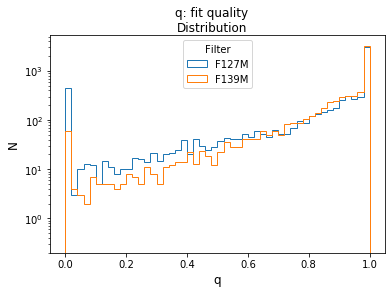

In [35]:
# distribution of q from the master catalog
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), 
#                          sharex=True, sharey=True)
fig, ax = plt.subplots(nrows=1, ncols=1, 
                       sharex=True, sharey=True)

fig.suptitle("q: fit quality\nDistribution")


#filter_ind = 1
#    filter_ind = i+1
for filter_ind in [1, 2]:
    n, bins, patches = ax.hist(q_hists[filter_ind][1][:-1],
                               q_hists[filter_ind][1],
                               weights=q_hists[filter_ind][0],
                               log=True,
                               histtype='step', 
                               label=ks2_utils.get_filter_name_from_ks2id(f'F{filter_ind}')
                              );
ax.set_xlabel('q')
ax.set_ylabel('N')
ax.legend(title='Filter', loc='upper center')
# ax.set_ylim(1)
if False:
    fig.savefig(figpath / "q-distro.png")

In [36]:
from scipy.interpolate import interp1d

F127M
0.70	0.79	5202
0.80	0.74	4838
0.85	0.69	4511
0.90	0.63	4104
0.95	0.52	3419
F139M
0.70	0.90	5866
0.80	0.83	5442
0.85	0.78	5110
0.90	0.69	4528
0.95	0.58	3791


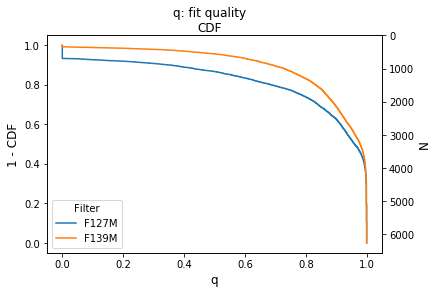

In [37]:
# distribution of q from the master catalog
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8), 
#                          sharex=True, sharey=True)
fig, ax = plt.subplots(nrows=1, ncols=1, 
                       sharex=True, sharey=True)

# for plotting the absolute number
abs_ax = ax.twinx()
abs_ax.invert_yaxis()

fig.suptitle("q: fit quality\nCDF")


#filter_ind = 1
#    filter_ind = i+1
for filter_ind in [1, 2]:
    color = f'C{filter_ind-1}'
    #ax.set_title('Filter: '+ks2_utils.get_filter_name_from_ks2id(f'F{filter_ind}'))
    cdf = np.cumsum(np.ones_like(master_catalog_df[f'q{filter_ind}']))-1
    cdf = cdf/cdf.size
    cdf_interp = interp1d(master_catalog_df[f'q{filter_ind}'].sort_values(), cdf)
    ax.plot(master_catalog_df[f'q{filter_ind}'].sort_values(),
            1-cdf,
            ls='-',
            label=ks2_utils.get_filter_name_from_ks2id(f'F{filter_ind}'),
            c=color
           )
#     # these lines show the intersections of the CDF with various thresholds
#     # but actually they make the plot too cluttered
#     # so just calculate and report as a table; don't plot
    q_thresholds = [0.7, 0.8, 0.85, 0.9, 0.95]
    frac_below = 1-cdf_interp(q_thresholds)
    print(ks2_filtermapper.query(f"filter_id == 'F{filter_ind}'")['filter_name'].values[0])
    for thresh, fb in zip(q_thresholds, frac_below):
        horz = (0, thresh)
        vert = (0, fb)
        print(f"{thresh:0.2f}\t{fb:0.2f}\t{fb*cdf.size:0.0f}")
#         args = {'lw':1, 'c':color, 'ls':'--', 'alpha':0.7}
#         ax.axhline(vert[1], horz[0], horz[1], 
#                    **args)
#         ax.axvline(horz[1], vert[0], vert[1], 
#                    **args)

    abs_ax.plot(master_catalog_df[f'q{filter_ind}'].sort_values(),
                cdf*cdf.size, 
                color='none', 
                )
        
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(-0.05, 1.05)

ax.set_xlabel('q')
ax.set_ylabel('1 - CDF')
ax.legend(title='Filter', loc='lower left')

abs_ax.set_ylim(cdf.size, 0)
abs_ax.set_ylabel("N")
if True:
    fig.savefig(figpath / "q-distro_cumulative.png")

## First off, we can see that a bunch of stars have q=0. What does that look like?

In [38]:
q0_stars = brightest_stars.query('q1 == 0 or q2 == 0')
q0_stars.head()

,umast0,vmast0,mmast1,NMAST,zmast1,szmast1,q1,o1,f1,g1,zmast2,szmast2,q2,o2,f2,g2
945,1443.95,977.69,-6.9229,R0004888,587.723,33.632,0.964,9.15,9,8,-263.334,243.644,0.0,625.96,13,13
1777,50.02,651.46,-5.7155,R0001950,193.282,4.033,0.999,6.17,9,9,0.000,99999.000,0.0,0.00,0,0
1984,50.82,648.65,-5.3572,R0001972,138.956,2.255,0.998,9.87,9,9,0.000,99999.000,0.0,0.00,0,0
2888,51.69,665.49,-3.8756,R0001951,35.500,2.304,0.993,0.05,9,9,0.000,99999.000,0.0,0.00,0,0
2958,1389.74,1016.80,-3.7737,R0004874,32.320,2.830,0.894,0.25,8,7,-25.218,5.683,0.0,8.13,9,9


In [39]:
keys = q0_stars['NMAST']
q0_pointsources = point_sources_df[point_sources_df.eval(f"NMAST in @keys")]#.reset_index(drop=True)

In [40]:
q0_pointsources.columns

Index(['umast', 'vmast', 'magu', 'utile', 'vtile', 'z0', 'sz0', 'f0', 'g0',
       'u1', 'v1', 'x1', 'y1', 'xraw1', 'yraw1', 'z1', 'sz1', 'q1', 'o1', 'f1',
       'g1', 'x0', 'y0', 'z2', 'sz2', 'q2', 'o2', 'f2', 'g2', 'z3', 'sz3',
       'q3', 'o3', 'f3', 'g3', 'NMAST', 'ps_tile_id', 'tile_id',
       'master_exp_id', 'filt_id', 'unk', 'chip_id'],
      dtype='object')

In [41]:
q0_pointsources.query("NMAST == 'R0004197'")[['NMAST','master_exp_id', 'q1','q2', 'q3', 'z1','z2','z3', 'filt_id']]

,NMAST,master_exp_id,q1,q2,q3,z1,z2,z3,filt_id
141311,R0004197,G026,0.9514,0.9686,0.9948,15.4,23.5,17.6,F2
141312,R0004197,G027,0.9556,0.9496,1.0000,13.6,11.4,18.0,F2
141313,R0004197,G028,0.9929,0.9889,1.0000,21.4,24.0,21.3,F2
141314,R0004197,G037,0.9774,0.9587,0.9929,19.3,18.2,17.5,F2
141315,R0004197,G038,0.9631,0.9586,1.0000,16.2,17.7,15.8,F2
141316,R0004197,G042,0.9952,0.9747,0.9928,16.5,16.0,19.9,F2
141317,R0004197,G044,0.9761,0.9734,0.9983,16.9,13.6,20.3,F2
141318,R0004197,G046,0.9766,0.9763,0.9997,14.7,14.2,15.5,F2
141319,R0004197,G055,0.9647,0.9601,1.0000,16.1,14.0,19.7,F2


In [42]:
brightest_stars.query("NMAST == 'R0004197'")[['NMAST', 'q1','q2', 'zmast1', 'szmast1', 'zmast2', 'szmast2', ]]

,NMAST,q1,q2,zmast1,szmast1,zmast2,szmast2
6155,R0004197,0.0,0.973,0.0,99999.0,16.745,1.903


In [43]:
# get stamps
ps_ind = q0_pointsources.index[np.random.randint(q0_pointsources.shape[0])]
# ps_ind = 1522 # if you need to cheat
flt_file = ks2_utils.get_file_name_from_ks2id(q0_pointsources.loc[ps_ind, 'master_exp_id'])
reload(shared_utils)
data = fits.getdata(shared_utils.get_data_file(flt_file), 1)
# image_utils.get_stamp()

In [44]:
reload(image_utils)

<module 'utils.image_utils' from '/user/jaguilar/tr14/code/utils/image_utils.py'>

In [45]:
xy = q0_pointsources.loc[ps_ind, ['xraw1','yraw1']].values
stamp, ind = image_utils.get_stamp(data, 
                                   xy, 
                                   30,
                                   return_img_ind=True)

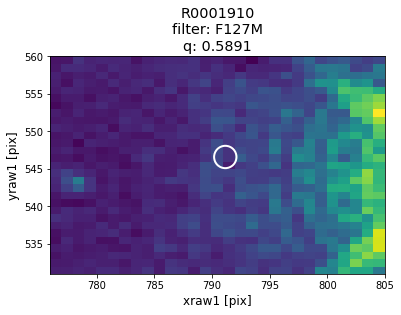

In [46]:
fig, ax = plt.subplots(1, 1)
ax.set_title('\n'.join([q0_pointsources.loc[ps_ind, 'NMAST'],
                        'filter: ' + ks2_utils.get_filter_name_from_ks2id(q0_pointsources.loc[ps_ind, 'filt_id']), 
                        'q: ' + str(q0_pointsources.loc[ps_ind, 'q'+q0_pointsources.loc[ps_ind, 'filt_id'][1]])])
            )
ax.set_xlabel("xraw1 [pix]")
ax.set_ylabel("yraw1 [pix]")
ax.pcolor(ind[1], ind[0], stamp, norm=mpl.colors.LogNorm())
ax.scatter(*xy, marker='o', s=500, fc='none', lw=2, ec='w')

## So, which stars have the poorest fits?

In [47]:
brightest_stars.columns

Index(['umast0', 'vmast0', 'mmast1', 'NMAST', 'zmast1', 'szmast1', 'q1', 'o1',
       'f1', 'g1', 'zmast2', 'szmast2', 'q2', 'o2', 'f2', 'g2'],
      dtype='object')

In [48]:
plot_columns = ['mmast', 'zmast', 'szmast', 'q', 'o']

In [49]:
# pairplot is not a good tool for this
# filter_ind = 1
# pairax = sns.pairplot(brightest_stars.loc[::50],
#                       vars=[i+f'{filter_ind}' for i in plot_columns], 
#                       diag_kws={'bins':50}, 
#                       plot_kws={'size':10, 'marker':'o'},
#                       corner=True)

In [50]:

tmp_df = brightest_stars.query(f'zmast{filter_ind} > 0 and q{filter_ind} > 0')
np.any(np.isnan(np.log10(tmp_df[f'q{filter_ind}'])))

False

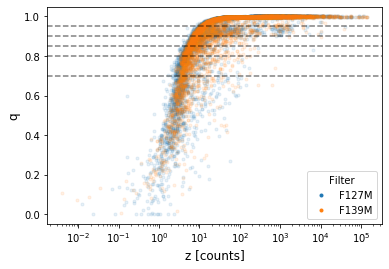

In [51]:
# plot magnitude/flux uncertainty against fit
fig, ax = plt.subplots(1, 1)

ax.set_xlabel("z [counts]")
ax.set_ylabel("q")

# you're going to take a log, so only use valid values
tmp_df = brightest_stars.query(f'zmast{filter_ind} > 0 and q{filter_ind} > 0')

lines = [] # for the llegend
for filter_ind in [1, 2]:
    color = f'C{filter_ind-1}'
#     sns.kdeplot(tmp_df[f'zmast{filter_ind}'],
#                 np.log10(tmp_df[f'q{filter_ind}']),
#                 shade=True,
#                 ax=ax)
    label=ks2_utils.get_filter_name_from_ks2id(f'F{filter_ind}')
    ax.plot(tmp_df[f'zmast{filter_ind}'],
            tmp_df[f'q{filter_ind}'], 
            '.', alpha=0.1, c=color,
            label=label)
    line = ax.plot([], [], '.', alpha=1, c=color, 
                   label=label)[0]
    lines.append(line)

ax.set_xscale("log")

for thresh in q_thresholds:
    ax.axhline(thresh, color='k', ls='--', alpha=0.5)

ax.legend(handles=lines, 
          labels=[line.get_label() for line in lines],
          loc='lower right', title='Filter')
if False:
    fig.savefig(figpath / "z_vs_q.png")

In [52]:
reload(ks2_utils)

<module 'utils.ks2_utils' from '/user/jaguilar/tr14/code/utils/ks2_utils.py'>

In [53]:
# make a dataframe out of the stds for all the q methods
# we only care about method #1, so q1
q_std = point_sources_df.groupby(["filt_id", "NMAST"])['q1'].aggregate(np.std)#.reset_index(level='filt_id')
# q_std.rename(columns={'q1':'sq'}, inplace=True)
q_std.name='sq'
q_std.head()

filt_id  NMAST   
F1       R0000001    0.082922
         R0000002    0.048359
         R0000003    0.000300
         R0000004    0.014623
         R0000005    0.001291
Name: sq, dtype: float64

In [54]:
ks2_filtermapper['filter_id'].apply(lambda x: x[-1])

0    1
1    2
Name: filter_id, dtype: object

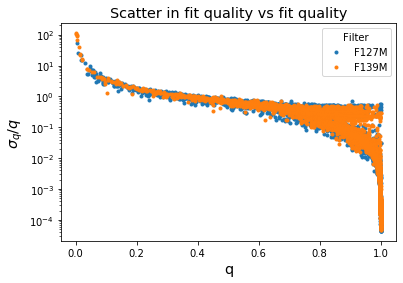

In [55]:
fig, ax = plt.subplots(1, 1)

ax.set_title("Scatter in fit quality vs fit quality")
ax.set_xlabel("q", fontsize='x-large')
ax.set_ylabel(r"$\sigma_q/q$", fontsize='x-large')
ax.set_yscale("log")

# generate q vs sigma_q on the fly
for filt_id in ks2_filtermapper['filter_id']:
    filter_name = ks2_utils.get_filter_name_from_ks2id(filt_id)
    tmp_df = pd.concat([brightest_stars.set_index('NMAST')[f'q{filt_id[-1]}'], 
                        q_std.loc[filt_id]], axis=1)
    tmp_df['rel_q'] = tmp_df['sq']/tmp_df[f'q{filt_id[-1]}']
    ax.plot(tmp_df[f'q{filt_id[-1]}'], 
            tmp_df['rel_q'], 
            '.', label=filter_name)
    
ax.legend(title='Filter')

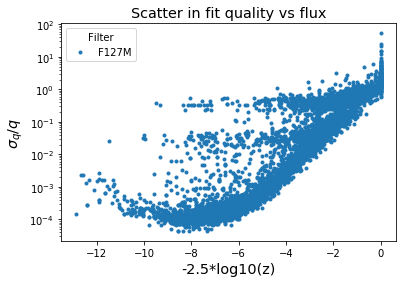

In [56]:
fig, ax = plt.subplots(1, 1)

ax.set_title("Scatter in fit quality vs flux")
ax.set_xlabel("-2.5*log10(z)", fontsize='x-large')
ax.set_ylabel(r"$\sigma_q/q$", fontsize='x-large')
ax.set_yscale("log")

# generate q vs sigma_q on the fly
for filt_id in ['F1']:
    filter_name = ks2_utils.get_filter_name_from_ks2id(filt_id)
    tmp_df = pd.concat([brightest_stars.set_index('NMAST')[f'q{filt_id[-1]}'],
                        brightest_stars.set_index('NMAST')[f'mmast{filt_id[-1]}'], 
                        q_std.loc[filt_id]], axis=1)
    tmp_df['rel_q'] = tmp_df['sq']/tmp_df[f'q{filt_id[-1]}']
    ax.plot(tmp_df[f'mmast{filt_id[-1]}'], 
            tmp_df['rel_q'], 
            '.', label=filter_name)
    
ax.legend(title='Filter')

In [104]:
tmp = brightest_stars.query('zmast1 > 0 and zmast2 > 0').copy()

In [109]:
tmp['logz1'] = tmp['zmast1'].apply(np.log10)
tmp['logz2'] = tmp['zmast2'].apply(np.log10)
tmp['logszrel1'] = np.log10(tmp['szmast1']/tmp['zmast1'])
tmp['logszrel2'] = np.log10(tmp['szmast2']/tmp['zmast2'])

In [130]:
point_sources_df.columns

Index(['umast', 'vmast', 'magu', 'utile', 'vtile', 'z0', 'sz0', 'f0', 'g0',
       'u1', 'v1', 'x1', 'y1', 'xraw1', 'yraw1', 'z1', 'sz1', 'q1', 'o1', 'f1',
       'g1', 'x0', 'y0', 'z2', 'sz2', 'q2', 'o2', 'f2', 'g2', 'z3', 'sz3',
       'q3', 'o3', 'f3', 'g3', 'NMAST', 'ps_tile_id', 'tile_id',
       'master_exp_id', 'filt_id', 'unk', 'chip_id'],
      dtype='object')

In [200]:
tmp

,umast0,vmast0,mmast1,NMAST,zmast1,szmast1,q1,o1,f1,g1,zmast2,szmast2,q2,o2,f2,g2,logz1,logz2,logszrel1,logszrel2
0,890.33,886.85,-12.8568,R0003688,138911.141,681.767,0.999,2.86,2,2,138139.625,2132.587,0.999,2.94,10,10,5.142737,5.140318,-2.309101,-1.811412
1,946.98,1326.65,-12.6689,R0005481,116826.969,9999.900,1.000,944.41,2,1,114944.219,2783.895,1.000,2488.15,11,6,5.067543,5.060487,-1.067547,-1.615834
2,699.97,452.63,-12.6607,R0001217,115947.625,9999.900,1.000,1.21,1,1,105570.305,1779.096,0.999,1.24,12,12,5.064262,5.023542,-1.064266,-1.773342
3,796.43,642.13,-12.5949,R0002206,109132.336,1475.222,0.998,2.74,6,6,111699.477,9273.528,0.999,2.89,22,21,5.037953,5.048051,-1.869096,-1.080806
4,991.21,734.01,-12.4650,R0002481,96826.672,1409.509,0.999,1.96,8,8,91708.797,2146.511,0.999,2.02,32,31,4.985995,4.962411,-1.836927,-1.630678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6098,1050.88,714.20,-0.0000,R0002541,0.100,0.557,0.139,0.47,6,5,6.538,3.540,0.780,1.61,33,33,-1.000000,0.815445,0.745855,-0.266442
6099,994.05,629.71,-0.0000,R0002530,0.079,1.597,0.000,0.00,14,14,1.710,2.253,0.400,0.00,29,29,-1.102373,0.232996,1.305678,0.119765
6100,563.53,822.05,-0.0000,R0003156,0.067,1.483,0.128,0.01,14,14,1.628,1.989,0.422,0.02,33,33,-1.173925,0.211654,1.345066,0.086980
6101,1269.10,279.12,-0.0000,R0001009,0.023,2.348,0.000,34.89,7,7,3.665,2.534,0.523,25.35,17,17,-1.638272,0.564074,2.008970,-0.160267


Text(27.125, 0.5, 'log($\\sigma_z/z$)')

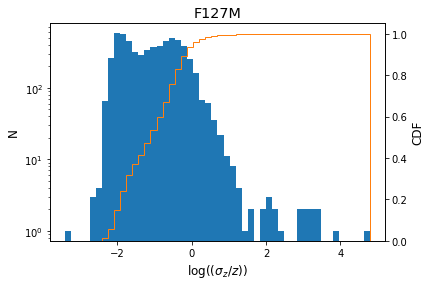

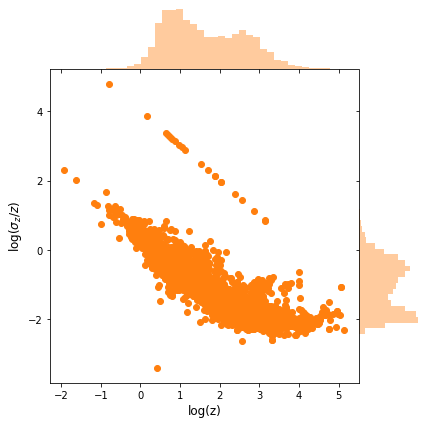

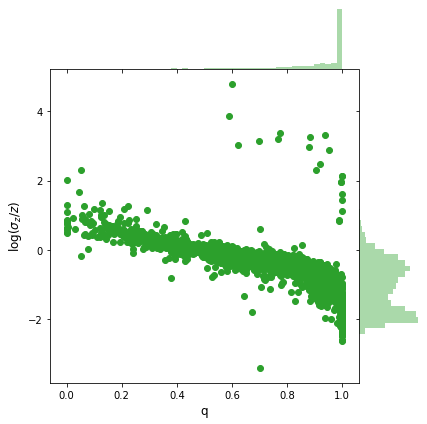

In [123]:
fig, ax = plt.subplots(1, 1)

ax.set_title(ks2_utils.get_filter_name_from_ks2id('F1'))
# show the distribution of relative uncertainty in z
ax.set_xlabel(r"log(($\sigma_z/z$))")
ax.set_ylabel(r"N")
hist = ax.hist(tmp['logszrel1'], bins=50, log=True)
cdf_ax = ax.twinx()
cdf_ax.set_ylabel("CDF")
cdf_ax.hist(tmp['logszrel1'], bins=hist[1], 
            histtype='step', cumulative=1, density=True,
            color='C1')

# plot relative flux uncertainty against flux
g = sns.jointplot(x='logz1', y='logszrel1', data=tmp,
                  color='C1',
                  space=0)
g.ax_joint.set_xlabel("log(z)")
g.ax_joint.set_ylabel(r"log($\sigma_z/z$)")


# plot relative flux uncertainty against q
# g = sns.jointplot(tmp['q1'],
#                   tmp['logszrel1'],
#                   space=0)
g = sns.jointplot(x='q1', y='logszrel1', data=tmp,
                  color='C2',
                  space=0)
g.ax_joint.set_xlabel("q")
g.ax_joint.set_ylabel(r"log($\sigma_z/z$)")

In [173]:
q_avg = point_sources_df.groupby(['filt_id', 'NMAST'])[['q1', 'q2', 'q3']].aggregate(np.mean)
q_err = point_sources_df.groupby(['filt_id', 'NMAST'])[['q1', 'q2', 'q3']].aggregate(np.std)
z_avg = point_sources_df.groupby(['filt_id', 'NMAST'])[['z1', 'z2', 'z3', 'sz1', 'sz2', 'sz3']].aggregate(np.mean)
z_avg[z_avg <= 0] = np.nan
z_log = pd.DataFrame(np.log10(z_avg[['sz1', 'sz2', 'sz3']].values/z_avg[['z1', 'z2', 'z3']].values),
                     columns=['z1','z2','z3'], index=z_avg.index)

In [174]:
z_log[z_log.applymap(np.isinf)] = np.nan

/Users/jaguilar/miniconda3/envs/astro37/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jaguilar/miniconda3/envs/astro37/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/jaguilar/miniconda3/envs/astro37/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jaguilar/miniconda3/envs/astro37/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/jaguilar/miniconda3/envs/astro37/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/jaguilar/miniconda3/envs/astro37/lib/python3.7/site-packages/num

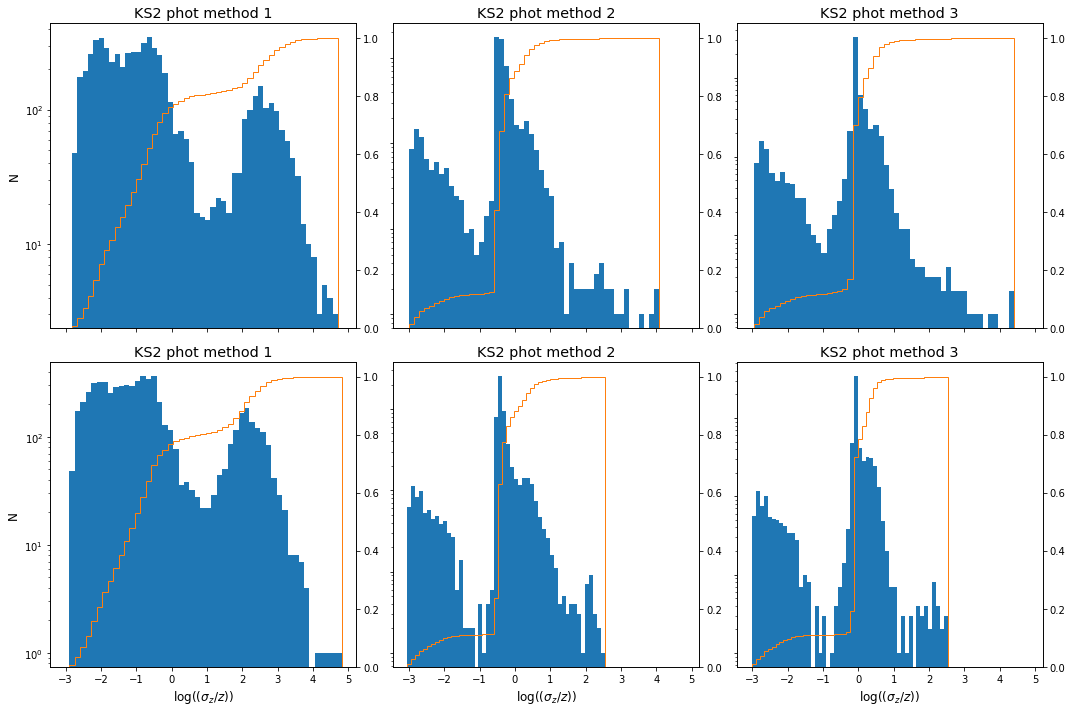

In [199]:
filt_id = '1'
meth_id = '1'

nrows, ncols = len(ks2_filtermapper), len(ks2_utils.phot_method_ids)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, 
                         figsize=(5*ncols, 5*nrows),
                        sharex=True, sharey=False)

# Filter 1
# fig.suptitle(ks2_utils.get_filter_name_from_ks2id('F'+filt_id))
for f_i, filt_id in enumerate(ks2_filtermapper['filter_id']):
    for m_i, ax in enumerate(axes[f_i]):
        meth_id = str(m_i+1)
        # these are all filter 1. Plot a histogram for each method
        # show the distribution of relative uncertainty in z
        ax.set_title(f"KS2 phot method {m_i+1}")
        ax.set_xlabel(r"log(($\sigma_z/z$))")
        ax.set_ylabel(r"N")
        hist = ax.hist(z_log.loc[filt_id, f'z{meth_id}'],#np.log10(z_avg[f'z{meth_id}']), 
                       bins=50, log=True)
        cdf_ax = ax.twinx()
#         cdf_ax.set_ylabel("CDF")
        cdf_ax.hist(z_log.loc[filt_id,f'z{meth_id}'], 
                    bins=hist[1], 
                    histtype='step', cumulative=1, density=True,
                    color='C1');

for ax in axes.ravel():
    try:
        ax.label_outer()
    except:
        pass
        
fig.tight_layout()
# # plot relative flux uncertainty against flux
# g = sns.jointplot(x=np.log10(z_avg[f'z{meth_id}']),
#                   y='logszrel1', data=tmp,
#                   color='C1',
#                   space=0)
# g.ax_joint.set_xlabel("log(z)")
# g.ax_joint.set_ylabel(r"log($\sigma_z/z$)")


# # plot relative flux uncertainty against q
# # g = sns.jointplot(tmp['q1'],
# #                   tmp['logszrel1'],
# #                   space=0)
# g = sns.jointplot(x='q1', y='logszrel1', data=tmp,
#                   color='C2',
#                   space=0)
# g.ax_joint.set_xlabel("q")
# g.ax_joint.set_ylabel(r"log($\sigma_z/z$)")

Text(27.125, 0.5, 'log($\\sigma_z/z$)')

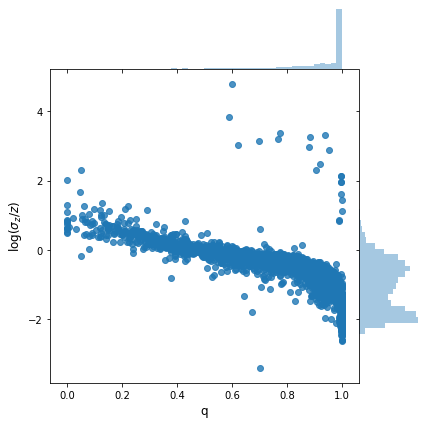

In [218]:
g = sns.JointGrid(x='q1', y='logszrel1', data=tmp,
                  space=0)
g.plot_joint(sns.regplot, ci=67, fit_reg=False, line_kws={'color':'C1'})
g.plot_marginals(sns.distplot, kde=False)
g.ax_joint.set_xlabel("q")
g.ax_joint.set_ylabel(r"log($\sigma_z/z$)")